In [ ]:
!unzip "/content/drive/My Drive/CSE445/CSE445 Dataset/jaffedbase.zip"

In [ ]:
!unzip "/content/drive/My Drive/CSE445/CSE445 Dataset/KDEF.zip" -d "./kdef"

In [ ]:
!tar -xvzf "/content/drive/My Drive/CSE445/CSE445 Dataset/cohn-kanade.tgz" -C "./ck"

**Preprocess JAFFE dataset**

In [2]:
import cv2 as cv
import os
import re
import numpy as np
import matplotlib.pyplot as plt

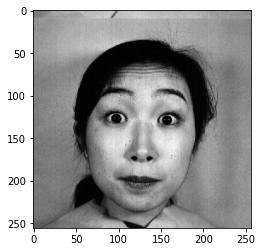

In [3]:
img = plt.imread("./jaffe/KA.SU1.36.tiff")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
gray = img.copy()
plt.imshow(img)
plt.show()

In [7]:
from imutils.face_utils import FaceAligner, rect_to_bb, shape_to_np
from imutils import resize
import dlib

In [6]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/drive/My Drive/CSE445/shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor)

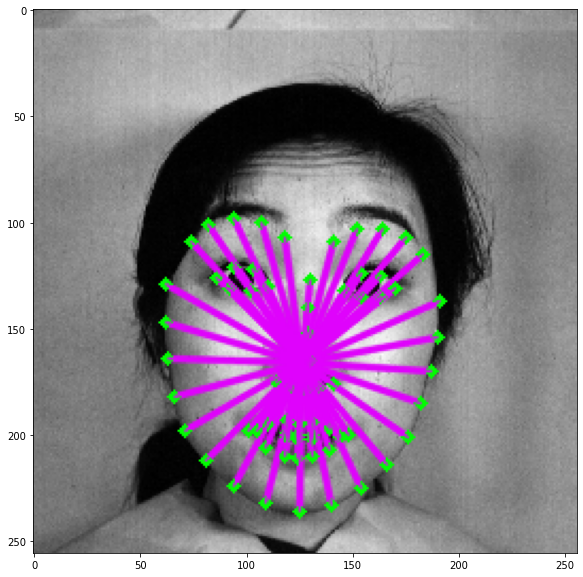

In [21]:
fig, ax = plt.subplots(figsize = (10, 10))
rects = detector(gray, 1)

for rect in rects:
  faceShape = predictor(gray, rect)
  faceShape = shape_to_np(faceShape)
  
  for (x, y) in faceShape:
    cv.circle(img, (x, y), 1, (0, 255, 0), 3)

  cogX = np.sum(faceShape[:, 0]) / faceShape.shape[0]
  cogY = np.sum(faceShape[:, 1]) / faceShape.shape[0]

  cv.circle(img, (int(cogX), int(cogY)), 1, (155, 0, 155), 1)

  for (x, y) in faceShape:
    cv.line(img, (int(cogX), int(cogY)), (x, y), (223, 3, 252), 1, cv.LINE_AA)
  
ax.imshow(img)
plt.show()

In [ ]:
# get the file names in the directory
jaffeImageList = os.listdir("./jaffe")
jaffeImageList = list(filter(lambda imageFileName: str(imageFileName).endswith("tiff"), jaffeImageList))
# jaffeImageList

In [ ]:
# the filenames are of the format <subject name>.<emotion><number>.<number>.extension
def GetEmotionLabel(regexPattern, imageFileName):
  matchObj = re.search(regexPattern, imageFileName)
  emotion = matchObj.groups()
  return emotion[0]

In [ ]:
jaffeImagePaths = list(map(lambda imageName: os.path.join(os.path.abspath("."), "jaffe", imageName), jaffeImageList))
jaffeImagePaths[:5]

['/content/jaffe/NA.NE1.199.tiff',
 '/content/jaffe/KR.SA3.79.tiff',
 '/content/jaffe/KL.HA1.158.tiff',
 '/content/jaffe/UY.DI2.150.tiff',
 '/content/jaffe/NM.SA2.99.tiff']

for each image
*   read the image
*   align the face if skewed
*   save it in separate folder under its proper emotion label

In [ ]:
def GetAlignedImage(imagePath):
  """
  Returns the properly aligned image of a face if it is skewed

  Returns None if no faces could be detected
  """
  img = cv.imread(imagePath)
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  rects = detector(img, 2)
  
  if len(rects) > 0:
    for rect in rects:
      # extract the ROI of the *original* face, then align the face
      # using facial landmarks
      (x, y, w, h) = rect_to_bb(rect)
      faceOrig = resize(img[y:y + h, x:x + w])
      faceAligned = fa.align(img, gray, rect)
      
    rects = detector(faceAligned, 2)
    
    if len(rects) > 0:
      # the datasets only have one face per frame
      rect = rects[0]
      (x, y, w, h) = rect_to_bb(rect)
      alignedImg = resize(faceAligned[y:y + h, x:x + w])
      
      return alignedImg

  return None

In [ ]:
def SaveImageUnderAppropriateFolder(emotionToFolderMapping, emotionRegexPatternInFileName, imagePaths, savePathRoot):
  """
  Saves the aligned images into a specified root folder under proper folders using a provided dict and regex pattern.

  Parameters:
  ----------

  emotionToFolderMapping: dict
    A dictionary that contains mapping of emotion label in image file name to actual folder name. It may look something like this:
      jaffeEmotionToFolderMapping = {
        "AN": "angry",
        "DI": "disgust",
        "HA": "happy",
        "NE": "neutral",
        "SA": "sad",
        "SU": "surprise"
      }
  
  emotionRegexPatternInFileName: str
    The regex pattern to search for in the image file name.
  
  imagePaths: list
    Paths to the images

  savePathRoot: str
    The root/destination folder where the aligned images will be saved after alignment

  Returns:
  --------
  None

  Raises:
  -------
  None
  """
  from tqdm import tqdm

  for imagePath in tqdm(imagePaths):
    imageFileName = imagePath.rsplit(os.sep, 1)[-1]
    emotion = GetEmotionLabel(emotionRegexPatternInFileName, imageFileName)

    # skip emotions that aren't part of the mapping dictionary
    if emotion not in emotionToFolderMapping.keys():
      continue

    alignedImage = GetAlignedImage(imagePath)

    # some images may not lead to a detection of face
    if alignedImage is None:
      continue

    folderName = emotionToFolderMapping[emotion]
    
    if not os.path.isdir(os.path.join(savePathRoot, folderName)):
      os.makedirs(os.path.join(savePathRoot, folderName), exist_ok = True)
    
    cv.imwrite(os.path.join(savePathRoot, folderName, imageFileName), alignedImage)

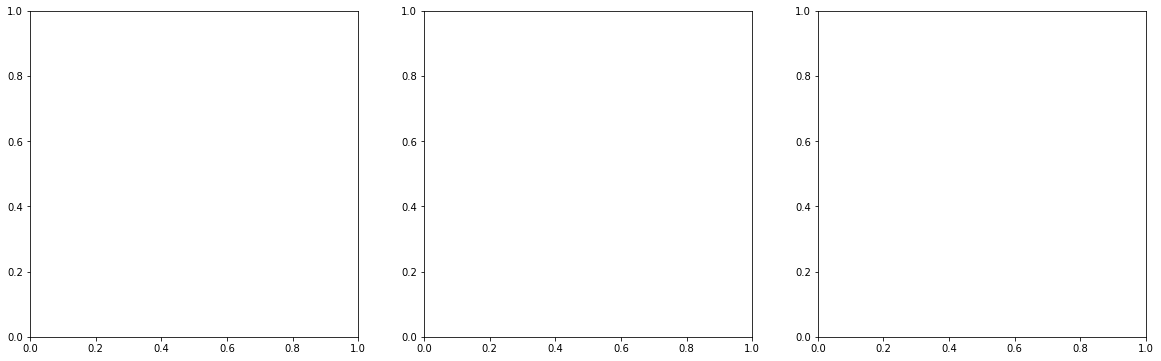

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize=(20, 6))

In [ ]:
for rect in rects:
  # extract the ROI of the *original* face, then align the face
	# using facial landmarks
  (x, y, w, h) = rect_to_bb(rect)
  faceOrig = resize(img[y:y + h, x:x + w])
  faceAligned = fa.align(img, gray, rect)
  # display the output images
  ax1.set_title("Original")
  ax1.imshow(faceOrig)
  ax2.set_title("Aligned")
  ax2.imshow(faceAligned)

In [ ]:
rects = detector(faceAligned, 2)

for rect in rects:
  (x, y, w, h) = rect_to_bb(rect)
  aligned = resize(faceAligned[y:y + h, x:x + w])
  ax3.set_title("Aligned Detection")
  ax3.imshow(aligned)

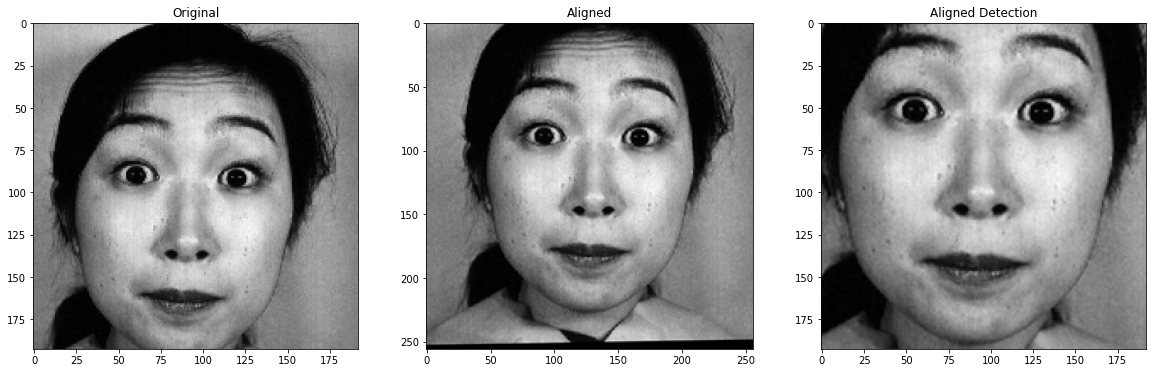

In [ ]:
fig

In [ ]:
jaffeEmotionRegexPattern = r"\w+\.(\w+)\d\.[\w.]*"
jaffeEmotionToFolderMapping = {
  "AN": "angry",
  "DI": "disgust",
  "HA": "happy",
  "NE": "neutral",
  "SA": "sad",
  "SU": "surprise"
}
jaffeAlignedImagesSavePathRoot = "/content/drive/My Drive/CSE445/CSE445 Dataset/jaffe-preprocessed"

In [ ]:
SaveImageUnderAppropriateFolder(jaffeEmotionToFolderMapping, jaffeEmotionRegexPattern, jaffeImagePaths, jaffeAlignedImagesSavePathRoot)

**Process CK Dataset**

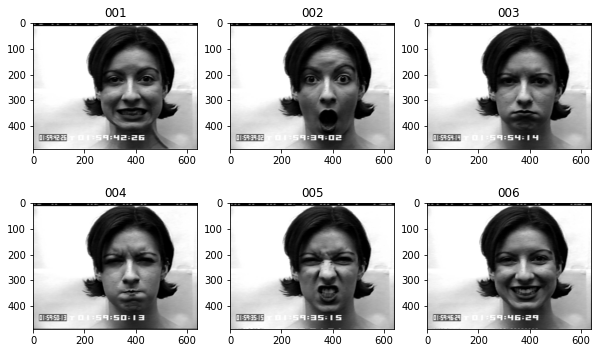

In [ ]:
imagesList = [
  "/content/ck/cohn-kanade/S010/001/S010_001_01594226.png",
  "/content/ck/cohn-kanade/S010/002/S010_002_01593902.png",
  "/content/ck/cohn-kanade/S010/003/S010_003_01595414.png",
  "/content/ck/cohn-kanade/S010/004/S010_004_01595013.png",
  "/content/ck/cohn-kanade/S010/005/S010_005_01593515.png",
  "/content/ck/cohn-kanade/S010/006/S010_006_01594629.png"
]

fig, *axes = plt.subplots(ncols = 3, nrows = 2, figsize = (10, 10), squeeze = True)
axes = [ax for sublist in axes[0] for ax in sublist]

for imagePath, ax in zip(imagesList, axes):
  img = plt.imread(imagePath)
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  ax.set_title(imagePath.rsplit(os.sep, 2)[-2])
  ax.imshow(img)

plt.subplots_adjust(bottom = 0.2, top = 0.7, hspace = 0)
plt.show()

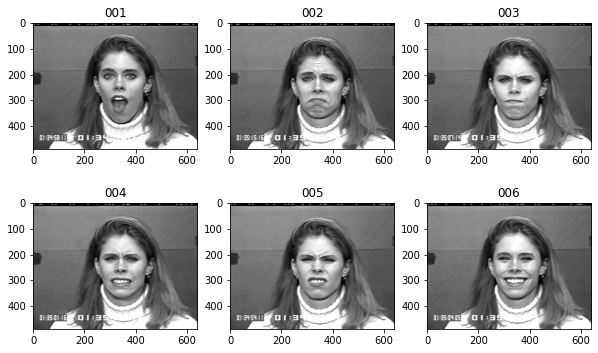

In [ ]:
imagesList = [
  "/content/ck/cohn-kanade/S032/001/S032_001_01345811.png",
  "/content/ck/cohn-kanade/S032/002/S032_002_01351516.png",
  "/content/ck/cohn-kanade/S032/003/S032_003_01350714.png",
  "/content/ck/cohn-kanade/S032/004/S032_004_01350116.png",
  "/content/ck/cohn-kanade/S032/005/S032_005_01345411.png",
  "/content/ck/cohn-kanade/S032/006/S032_006_01350405.png"
]

fig, *axes = plt.subplots(ncols = 3, nrows = 2, figsize = (10, 10), squeeze = True)
axes = [ax for sublist in axes[0] for ax in sublist]

for imagePath, ax in zip(imagesList, axes):
  img = plt.imread(imagePath)
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  ax.set_title(imagePath.rsplit(os.sep, 2)[-2])
  ax.imshow(img)

plt.subplots_adjust(bottom = 0.2, top = 0.7, hspace = 0)
plt.show()

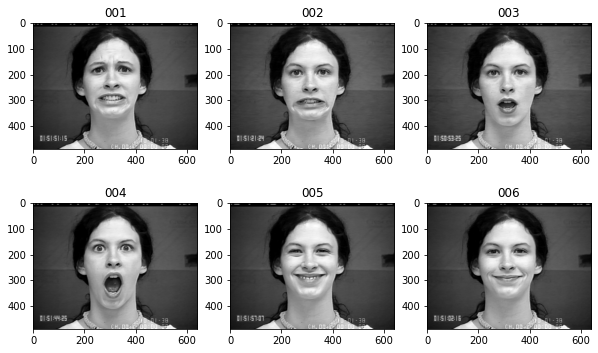

In [ ]:
imagesList = [
  "/content/ck/cohn-kanade/S138/001/S138_001_01515115.png",
  "/content/ck/cohn-kanade/S138/002/S138_002_01512124.png",
  "/content/ck/cohn-kanade/S138/003/S138_003_01505325.png",
  "/content/ck/cohn-kanade/S138/004/S138_004_01514425.png",
  "/content/ck/cohn-kanade/S138/005/S138_005_01515707.png",
  "/content/ck/cohn-kanade/S138/006/S138_006_01510216.png"
]

fig, *axes = plt.subplots(ncols = 3, nrows = 2, figsize = (10, 10), squeeze = True)
axes = [ax for sublist in axes[0] for ax in sublist]

for imagePath, ax in zip(imagesList, axes):
  img = plt.imread(imagePath)
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  ax.set_title(imagePath.rsplit(os.sep, 2)[-2])
  ax.imshow(img)

plt.subplots_adjust(bottom = 0.2, top = 0.7, hspace = 0)
plt.show()

In [ ]:
# manual labelling required

**Processing KDEF dataset**

In [ ]:
kdefRoot = "./kdef/KDEF"

In [ ]:
kdefEmotionRegexPattern = r"^[A-Z]+[0-9]+(\w{2})S"
kdefEmotionToFolderMapping = {
  "AN": "angry",
  "DI": "disgust",
  "HA": "happy",
  "NE": "neutral",
  "SA": "sad",
  "SU": "surprise"
}
kdefAlignedImagesSavePathRoot = "/content/drive/My Drive/CSE445/CSE445 Dataset/kdef-preprocessed"

In [ ]:
def match(path):
  path = path.rsplit(os.sep, 1)[-1]
  if re.search(kdefEmotionRegexPattern, path) is not None:
    return True
  return False

In [ ]:
subjectFolderPaths = list(map(lambda element: os.path.join(kdefRoot, element), os.listdir(kdefRoot)))

dataImagePaths = []

for subjectFolderPath in subjectFolderPaths:
  imagePaths = list(map(lambda element: os.path.join(subjectFolderPath, element), os.listdir(subjectFolderPath)))
  imagePaths = list(filter(match, imagePaths))
  dataImagePaths.extend(imagePaths)

print(dataImagePaths)

['./kdef/KDEF/AF10/AF10SUS.JPG', './kdef/KDEF/AF10/AF10ANS.JPG', './kdef/KDEF/AF10/AF10SAS.JPG', './kdef/KDEF/AF10/AF10HAS.JPG', './kdef/KDEF/AF10/AF10DIS.JPG', './kdef/KDEF/AF10/AF10AFS.JPG', './kdef/KDEF/AF10/AF10NES.JPG', './kdef/KDEF/BM24/BM24SUS.JPG', './kdef/KDEF/BM24/BM24NES.JPG', './kdef/KDEF/BM24/BM24HAS.JPG', './kdef/KDEF/BM24/BM24AFS.JPG', './kdef/KDEF/BM24/BM24DIS.JPG', './kdef/KDEF/BM24/BM24SAS.JPG', './kdef/KDEF/BM24/BM24ANS.JPG', './kdef/KDEF/BF31/BF31AFS.JPG', './kdef/KDEF/BF31/BF31SUS.JPG', './kdef/KDEF/BF31/BF31DIS.JPG', './kdef/KDEF/BF31/BF31NES.JPG', './kdef/KDEF/BF31/BF31ANS.JPG', './kdef/KDEF/BF31/BF31HAS.JPG', './kdef/KDEF/BF31/BF31SAS.JPG', './kdef/KDEF/AF31/AF31DIS.JPG', './kdef/KDEF/AF31/AF31AFS.JPG', './kdef/KDEF/AF31/AF31NES.JPG', './kdef/KDEF/AF31/AF31SUS.JPG', './kdef/KDEF/AF31/AF31SAS.JPG', './kdef/KDEF/AF31/AF31HAS.JPG', './kdef/KDEF/AF31/AF31ANS.JPG', './kdef/KDEF/AF15/AF15ANS.JPG', './kdef/KDEF/AF15/AF15NES.JPG', './kdef/KDEF/AF15/AF15SUS.JPG', './kdef

In [ ]:
SaveImageUnderAppropriateFolder(kdefEmotionToFolderMapping, kdefEmotionRegexPattern, dataImagePaths, kdefAlignedImagesSavePathRoot)